# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

### Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from langdetect import detect

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import string
import nltk
from nltk.corpus import stopwords

import textblob
from textblob import TextBlob

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report

%matplotlib inline

### Collect data and read the Dataframe

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | My husband and myself were ...
1,✅ Trip Verified | Organised boarding process. ...
2,✅ Trip Verified | Outward journey BA245 Londo...
3,✅ Trip Verified | Check in agent at LHR was ve...
4,✅ Trip Verified | Very disappointing. I book ...


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

### Exploratory Data Analysis

In [4]:
df.head()

,reviews
0,✅ Trip Verified | My husband and myself were ...
1,✅ Trip Verified | Organised boarding process. ...
2,✅ Trip Verified | Outward journey BA245 Londo...
3,✅ Trip Verified | Check in agent at LHR was ve...
4,✅ Trip Verified | Very disappointing. I book ...


In [5]:
df.shape

(1000, 1)

In [6]:
df.isnull().sum()

reviews    0
dtype: int64

### Dataframe preprocess and visualization

In [7]:
#Split reviews column
split = df["reviews"] .str.split("|")

In [8]:
verify = split.str.get(0)
review = split.str.get(1)

In [9]:
df["Verify"] = verify
df["Reviews"] = review

In [10]:
df.groupby(df.Verify).size()

Verify
Not Verified        169
✅ Trip Verified     829
❎ Not Verified        2
dtype: int64

In [11]:
# Delete emoji
df=df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [12]:
# Delete initial space
df['Verify'] = df['Verify'].str.strip()

In [13]:
df.groupby(df.Verify).size()

Verify
Not Verified     171
Trip Verified    829
dtype: int64

In [14]:
# Eliminate reviews column
df=df.drop("reviews", axis=1)

In [15]:
#detect language of Reviews
def detect_textlang(Reviews):
    try:
        src_lang = detect(Reviews)
        if src_lang =='en':
            return 'en'
        else:
        #return "NA"    
            return src_lang
    except:
        return "NA"
df['text_lang']=df.Reviews.apply(detect_textlang)

In [16]:
df.groupby(df.text_lang).size()

text_lang
en    1000
dtype: int64

<AxesSubplot: >

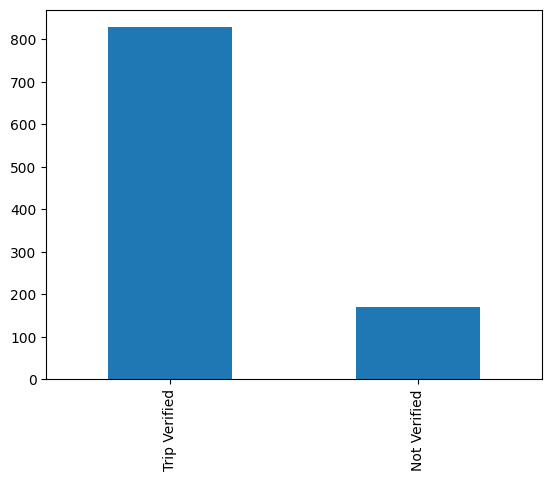

In [17]:
# Count of verify reviews
df["Verify"].value_counts().plot.bar()

### Prepared the dataframe for sentiment analysis

In [18]:
# Remove punctuation
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['Reviews'] = df['Reviews'].apply(remove_punctuation)

In [19]:
# Covert Reviews to lower-case
df['Reviews']=df['Reviews'].str.lower()

In [20]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
                   "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
                   "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
                   "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
                   "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", 
                   "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", 
                   "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
                   "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how",
                   "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
                   "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", 
                   "now",'anyone','today','yesterday','day', 'already','season', 'know'])
textt = " ".join(review for review in df.Reviews)

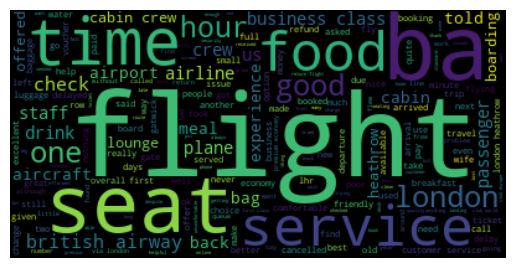

In [21]:
#Create a Wordcloud
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

WordCloud - Some popular words that can be observed here include “flight” “service” “time” and “food”.<br>
These words are mostly positive, also indicating that most reviews in the dataset express a positive sentiment.

In [22]:
# Create a list of words
words = " ".join(df["Reviews"])

# Count the number of times each word appears
word_counts = wordcloud.process_text(words)

# Create a list of the most common words and their counts
word_list = [(k, v) for k, v in word_counts.items()]
word_list.sort(key=lambda x: x[1], reverse=True)

# Convert the list to a DataFrame
df_wordcloud = pd.DataFrame(word_list, columns=["Word", "Count"])

# Print the DataFrame
print(df_wordcloud.head(10))

      Word  Count
0   flight   1643
1       ba   1032
2     seat    803
3     time    505
4  service    497
5     food    477
6   london    435
7      one    422
8     good    406
9     hour    384


### Rating the Reviews

In [23]:
# Define function to obtain Polarity Score
def getPolarity(df):
    return TextBlob(df).sentiment.polarity

# Define function to obtain Sentiment category
def getSentimentTextBlob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [24]:
# Apply the functions to respective columns
df['Polarity']=df['Reviews'].apply(getPolarity)
df['Sentiment']=df['Polarity'].apply(getSentimentTextBlob)
df['Sentiment'].value_counts()
df.head()

,Verify,Reviews,text_lang,Polarity,Sentiment
0,Trip Verified,my husband and myself were flying to madrid ...,en,0.098750,Positive
1,Trip Verified,organised boarding process really friendly cr...,en,0.627083,Positive
2,Trip Verified,outward journey ba245 london to buenos aires...,en,-0.014712,Negative
3,Trip Verified,check in agent at lhr was very helpful and fr...,en,0.014670,Positive
4,Trip Verified,very disappointing i book ba so i can fly du...,en,0.024286,Positive


In [25]:
# Sentiment count
Sentiment = df['Sentiment'].tolist()
counts = Counter(Sentiment)
Sentiment_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
Sentiment_df.columns = ['Sentiment', 'Count']
Sentiment_df.sort_values(by='Count', ascending=False, inplace=True)
Sentiment_df.head()

,Sentiment,Count
0,Positive,670
1,Negative,321
2,Neutral,9


In [28]:
#Visualization of Sentiments Reviews
color = sns.color_palette()
fig = px.histogram(df, x="Sentiment")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Sentiment of Reviews')
fig.show()

<Figure size 640x480 with 0 Axes>

As we can see data is unbalanced so this will create problem for model but, will take this data as it is
and will predict our reviews

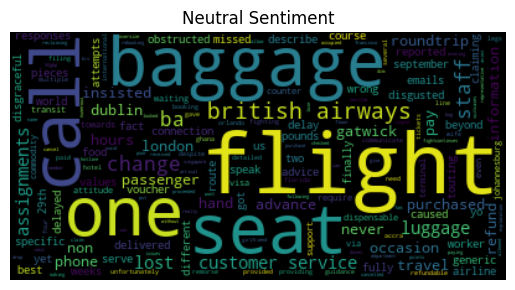

In [29]:
#WordCloud of each sentiment
#split df - neutral, positive and negative
#Neutral Sentiment

neutral = df.groupby(df.Sentiment)
df_neutral = neutral.get_group("Neutral")

text_neutral = " ".join(review for review in df_neutral.Reviews)
wordcloud2 = WordCloud(stopwords=stopwords).generate(text_neutral)

plt.imshow(wordcloud2, interpolation='bilinear')
plt.title ("Neutral Sentiment")
plt.axis("off")
plt.show()

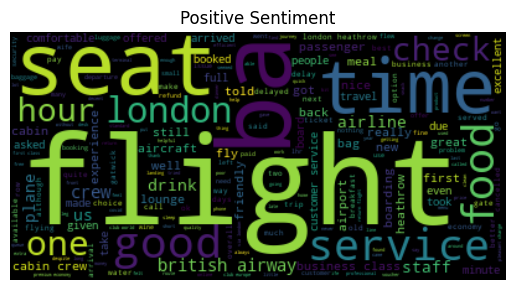

In [30]:
#Positive Sentiment 
positive = df.groupby(df.Sentiment)
df_positive = neutral.get_group("Positive")

text_positive = " ".join(review for review in df_positive.Reviews)
wordcloud3 = WordCloud(stopwords=stopwords).generate(text_positive)

plt.imshow(wordcloud3, interpolation='bilinear')
plt.title ("Positive Sentiment")
plt.axis("off")
plt.show()

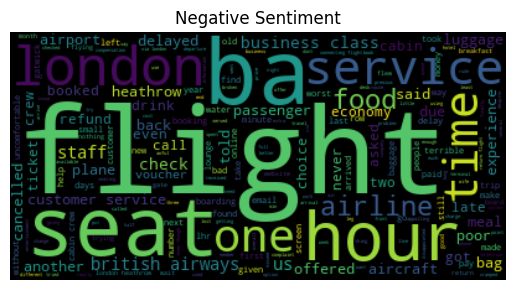

In [31]:
#Negative Sentiment
stopwords.update("time", "london")

negative = df.groupby(df.Sentiment)
df_negative = neutral.get_group("Negative")

text_negative = " ".join(review for review in df_negative.Reviews)
wordcloud4 = WordCloud(stopwords=stopwords).generate(text_negative)

plt.imshow(wordcloud4, interpolation='bilinear')
plt.title ("Negative Sentiment")
plt.axis("off")
plt.show()

### Creation and Assessment of Classification Models

In [32]:
#Create a new dataframe
dfnew=df[['Reviews','Sentiment']]

In [33]:
## Fitting Naive Bayes
# Train | Test Split
X_train, X_test, y_train, y_test = train_test_split(df["Reviews"], df["Sentiment"], 
                                                    test_size=0.2,
                                                    random_state = 700)
#Create a bag of words
vectorizer = CountVectorizer(binary=True)
X_train_vectorized = vectorizer.fit_transform(X_train)

#Fitting Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

#Make predictions 
X_test_vectorized = vectorizer.transform(X_test)
y_pred = nb_model.predict(X_test_vectorized)

#Evaluation of accuracy
acc = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy: {:.2f}%".format(acc * 100))

Naive Bayes Accuracy: 69.00%


In [34]:
#Model Performance Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 28   0  52]
 [  2   0   2]
 [  6   0 110]]
              precision    recall  f1-score   support

    Negative       0.78      0.35      0.48        80
     Neutral       0.00      0.00      0.00         4
    Positive       0.67      0.95      0.79       116

    accuracy                           0.69       200
   macro avg       0.48      0.43      0.42       200
weighted avg       0.70      0.69      0.65       200



/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [37]:
# Fitting Bernouli NB
# Train | Test Split
X2_train, X2_test, y2_train, y2_test = train_test_split(df["Reviews"], df["Sentiment"], 
                                                    test_size=0.2,
                                                    random_state = 700)
#Create a bag of words
vectorizer = CountVectorizer(binary=True)
X2_train_vectorized = vectorizer.fit_transform(X2_train)

#Fitting Bernouli NB
b_model = BernoulliNB()
b_model.fit(X2_train_vectorized, y2_train)

#Make predictions 
X2_test_vectorized = vectorizer.transform(X2_test)
y2_pred = b_model.predict(X2_test_vectorized)

#Evaluation of accuracy
acc = accuracy_score(y2_test, y2_pred)
print("Bernouli NB Accuracy: {:.2f}%".format(acc * 100))

Bernouli NB Accuracy: 64.50%


In [38]:
#Model Performance Evaluation
print(confusion_matrix(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

[[ 19   0  61]
 [  0   0   4]
 [  6   0 110]]
              precision    recall  f1-score   support

    Negative       0.76      0.24      0.36        80
     Neutral       0.00      0.00      0.00         4
    Positive       0.63      0.95      0.76       116

    accuracy                           0.65       200
   macro avg       0.46      0.40      0.37       200
weighted avg       0.67      0.65      0.58       200



/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [39]:
# Train | Test Split
X3_train, X3_test, y3_train, y3_test = train_test_split(df["Reviews"], df["Sentiment"], 
                                                    test_size=0.2,
                                                    random_state = 700)
#Create a bag of words
vectorizer = CountVectorizer(binary=True)
X3_train_vectorized = vectorizer.fit_transform(X3_train)

#Fitting Logistic Regression
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X3_train_vectorized, y3_train)

#Make predictions 
X3_test_vectorized = vectorizer.transform(X3_test)
y3_pred = lr_model.predict(X3_test_vectorized)

#Evaluation of accuracy
acc = accuracy_score(y3_test, y3_pred)
print("Logistic Regression Accuracy: {:.2f}%".format(acc * 100))

Logistic Regression Accuracy: 75.50%


In [41]:
#Model Performance Evaluation
print(confusion_matrix(y3_test, y3_pred))
print(classification_report(y3_test, y3_pred))

              precision    recall  f1-score   support

    Negative       0.79      0.56      0.66        80
     Neutral       0.00      0.00      0.00         4
    Positive       0.74      0.91      0.82       116

    accuracy                           0.76       200
   macro avg       0.51      0.49      0.49       200
weighted avg       0.75      0.76      0.74       200



/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/liviasimoes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [46]:
#Let test our classifiers with some handwritten samples
# Test the sentence
sentence1 = "British airways is great, I really enjoyed it!"
sentence1_features = vectorizer.transform([sentence1])
sentence1_prediction = lr_model.predict(sentence1_features)

sentence2 = "Very disappointed. The flight was delayed, we were at the airport for hours"
sentence2_features = vectorizer.transform([sentence2])
sentence2_prediction = lr_model.predict(sentence2_features)

sentence3 = "the whole experience was horrible and product is worst"
sentence3_features = vectorizer.transform([sentence3])
sentence3_prediction = lr_model.predict(sentence3_features)


# Print the prediction
print("Sentence:", sentence1,)
print("Sentiment Prediction:", sentence1_prediction)
print("\n")
print("Sentence:", sentence2,)
print("Sentiment Prediction:", sentence2_prediction)
print("\n")
print("Sentence:", sentence3,)
print("Sentiment Prediction:", sentence3_prediction)

Sentence: British airways is great, I really enjoyed it!
Sentiment Prediction: ['Positive']


Sentence: Very disappointed. The flight was delayed, we were at the airport for hours
Sentiment Prediction: ['Negative']


Sentence: the whole experience was horrible and product is worst
Sentiment Prediction: ['Negative']
